
# Climate Envelope of Ancient Sites in the Levant

- A transparent, reproducible presence–background model to predict where ancient sites are most likely in the South Levant, using modern climate, terrain, and distance to water.
- Out-of-fold performance is strong: AUC 0.953, AP 0.593, Brier 0.0567 (dataset prevalence ≈ 0.091).
- The model says seasonality dominates (temperature & precipitation seasonality), with proximity to rivers and terrain refining suitability.
- The Folium map highlights river corridors and Mediterranean belts as high-suitability zones.
- This is a quick, fun proof-of-concept, not a full research project.


## 0) Environment & imports

In [1]:

# If running fresh, you may need to install per requirements.txt
# !pip install geopandas shapely pyproj rasterio rioxarray xarray scikit-learn matplotlib tqdm pyarrow pandas numpy

import os, io, zipfile, math, itertools, warnings, urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
from shapely.ops import unary_union

import xarray as xr
import rioxarray as rxr
import rasterio
from rasterio.enums import Resampling

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt
from tqdm import tqdm
warnings.filterwarnings('ignore')


## 1) Config

In [2]:

DATA_DIR = Path('./data'); DATA_DIR.mkdir(exist_ok=True, parents=True)
OUT_DIR  = Path('./outputs'); OUT_DIR.mkdir(exist_ok=True, parents=True)

# --- Wider AOI: South Levant ---
S_BOUND, N_BOUND = 29.0, 34.8
W_BOUND, E_BOUND = 34.0, 37.6

# --- Archaeology dataset path (set this!) ---
ARCHAEO_GPKG = DATA_DIR / 'archaeo_sites.gpkg'    # replace if your filename differs
ARCHAEO_CSV  = None                               # OR set a CSV path with lon/lat columns

# --- WorldClim BIO (1970–2000) & Elevation ---
WC_BASE = 'https://geodata.ucdavis.edu/climate/worldclim/2_1/base'
WORLDCLIM_BIO_ZIP_URL = f'{WC_BASE}/wc2.1_2.5m_bio.zip'
WORLDCLIM_ELEV_ZIP_URL = f'{WC_BASE}/wc2.1_2.5m_elev.zip'
WORLDCLIM_DIR = DATA_DIR / 'worldclim_2_1_2p5m'
WORLDCLIM_DIR.mkdir(exist_ok=True, parents=True)

BIO_VARS = [1, 4, 12, 15]  # keep simple, can extend

# --- Natural Earth (coastline, rivers) ---
NE_DIR = DATA_DIR / 'natural_earth_50m'; NE_DIR.mkdir(exist_ok=True, parents=True)
NE_COAST_URL  = 'https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip'
NE_RIVERS_URL = 'https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_rivers_lake_centerlines.zip'

# --- Background sampling ---
BG_RATIO = 10     # backgrounds per presence
BG_CAP   = 20000  # max backgrounds

# --- CV ---
N_FOLDS = 5
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


## 2) Utilities: download & unzip

In [3]:

def download_if_missing(url: str, dest: Path):
    dest = Path(dest)
    if dest.exists():
        return dest
    dest.parent.mkdir(parents=True, exist_ok=True)
    print(f'Downloading: {url}')
    urllib.request.urlretrieve(url, dest)
    print(f'  -> {dest}')
    return dest

def unzip_if_missing(zip_path: Path, out_dir: Path):
    out_dir = Path(out_dir)
    if out_dir.exists() and any(out_dir.iterdir()):
        return out_dir
    print(f'Extracting {zip_path.name} -> {out_dir}')
    out_dir.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)
    return out_dir


## 3) Fetch rasters (BIO + elevation) & Natural Earth vectors

In [4]:
from zipfile import ZipFile
from pathlib import Path

# Subfolders for extracted GeoTIFFs
BIO_DIR  = WORLDCLIM_DIR / 'bio'
ELEV_DIR = WORLDCLIM_DIR / 'elev'
BIO_DIR.mkdir(parents=True, exist_ok=True)
ELEV_DIR.mkdir(parents=True, exist_ok=True)

def unzip_if_missing(zip_path: Path, out_dir: Path, expect_files: list[str]):
    """
    Extract zip_path into out_dir only if expect_files are not all present.
    expect_files are basenames relative to out_dir.
    """
    out_dir = Path(out_dir)
    need = not all((out_dir / f).exists() for f in expect_files)
    if not need:
        return out_dir
    print(f'Extracting {zip_path.name} -> {out_dir}')
    out_dir.mkdir(parents=True, exist_ok=True)
    with ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)
    return out_dir

# WorldClim BIO
bio_zip  = download_if_missing(WORLDCLIM_BIO_ZIP_URL, WORLDCLIM_DIR / 'wc2.1_2.5m_bio.zip')
unzip_if_missing(
    bio_zip, BIO_DIR,
    expect_files=[f'wc2.1_2.5m_bio_{v}.tif' for v in BIO_VARS]
)

# WorldClim Elevation
elev_zip = download_if_missing(WORLDCLIM_ELEV_ZIP_URL, WORLDCLIM_DIR / 'wc2.1_2.5m_elev.zip')
unzip_if_missing(
    elev_zip, ELEV_DIR,
    expect_files=['wc2.1_2.5m_elev.tif']
)

# Natural Earth vectors (same logic as before)
def unzip_simple(zip_path: Path, out_dir: Path):
    out_dir = Path(out_dir)
    if out_dir.exists() and any(out_dir.iterdir()):
        return out_dir
    print(f'Extracting {zip_path.name} -> {out_dir}')
    out_dir.mkdir(parents=True, exist_ok=True)
    with ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)
    return out_dir

ne_coast_zip  = download_if_missing(NE_COAST_URL, NE_DIR / 'ne_50m_coastline.zip')
ne_rivers_zip = download_if_missing(NE_RIVERS_URL, NE_DIR / 'ne_50m_rivers_lake_centerlines.zip')
unzip_simple(ne_coast_zip,  NE_DIR / 'coast')
unzip_simple(ne_rivers_zip, NE_DIR / 'rivers')


PosixPath('data/natural_earth_50m/rivers')

## 4) Load rasters and helpers

In [5]:
def open_bio_layers(bio_vars=BIO_VARS):
    layers = {}
    for v in bio_vars:
        p = BIO_DIR / f'wc2.1_2.5m_bio_{v}.tif'
        if not p.exists():
            raise FileNotFoundError(p)
        da = rxr.open_rasterio(p, masked=True).squeeze()
        da.name = f'bio{v}'
        layers[v] = da
    return layers

def open_elev_layer():
    p = ELEV_DIR / 'wc2.1_2.5m_elev.tif'
    if not p.exists():
        raise FileNotFoundError(p)
    da = rxr.open_rasterio(p, masked=True).squeeze()
    da.name = 'elev'
    return da

bio_layers = open_bio_layers()
elev_da    = open_elev_layer()


## 5) Derive slope (degrees) from elevation

In [6]:

# Reproject elevation to UTM 36N for metric gradients, then back to WGS84
elev_utm = elev_da.rio.reproject('EPSG:32636', resampling=Resampling.bilinear)
transform = elev_utm.rio.transform()
dx = abs(transform.a); dy = abs(transform.e)

arr = elev_utm.values.astype('float64')
# Handle masked arrays
if np.ma.isMaskedArray(arr):
    arr = arr.filled(np.nan)

dz_dy, dz_dx = np.gradient(arr, dy, dx)  # note order: rows->y, cols->x
slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
slope_deg = np.degrees(slope_rad)

slope_da = xr.DataArray(slope_deg, coords=elev_utm.coords, dims=elev_utm.dims, name='slope')
slope_da = slope_da.rio.write_crs(elev_utm.rio.crs)
slope_ll = slope_da.rio.reproject('EPSG:4326', resampling=Resampling.bilinear)


## 6) Load Natural Earth vectors (coast, rivers)

In [7]:

# Load shapefiles
coast_fp = list((NE_DIR / 'coast').glob('*.shp'))[0]
rivers_fp = list((NE_DIR / 'rivers').glob('*.shp'))[0]

coast_gdf = gpd.read_file(coast_fp).to_crs(4326)
rivers_gdf = gpd.read_file(rivers_fp).to_crs(4326)

# Clip to AOI buffer for speed
aoi = gpd.GeoSeries([box(W_BOUND-1, S_BOUND-1, E_BOUND+1, N_BOUND+1)], crs=4326)
coast_gdf = gpd.clip(coast_gdf, aoi.iloc[0])
rivers_gdf = gpd.clip(rivers_gdf, aoi.iloc[0])
print('Vectors:', len(coast_gdf), 'coast lines; ', len(rivers_gdf), 'river segments')


Vectors: 2 coast lines;  2 river segments


## 7) Load archaeology sites and ensure Points

In [8]:

def load_archaeo_sites():
    if ARCHAEO_GPKG and ARCHAEO_GPKG.exists():
        gdf = gpd.read_file(ARCHAEO_GPKG)
    elif ARCHAEO_CSV and Path(ARCHAEO_CSV).exists():
        df = pd.read_csv(ARCHAEO_CSV)
        assert {'lon','lat'}.issubset(df.columns)
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs=4326)
    else:
        raise FileNotFoundError('Set ARCHAEO_GPKG or ARCHAEO_CSV to a valid path.')
    return gdf.to_crs(4326)

def pointify(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf = gdf.explode(index_parts=False, ignore_index=True)
    gdf = gdf[gdf.geometry.notnull()].copy()
    def to_point(geom):
        if geom.is_empty: return None
        if geom.geom_type == 'Point': return geom
        if hasattr(geom, "geoms"):
            pts = [g for g in geom.geoms if g.geom_type == "Point"]
            if pts: return pts[0]
        return geom.representative_point()
    gdf['geometry'] = gdf['geometry'].apply(to_point)
    gdf = gdf.dropna(subset=['geometry']).to_crs(4326)
    return gdf

sites_gdf = pointify(load_archaeo_sites())
# Clip to AOI
sites_gdf = gpd.clip(sites_gdf, box(W_BOUND, S_BOUND, E_BOUND, N_BOUND))
print('Sites in AOI:', len(sites_gdf))


Sites in AOI: 69


## 8) Balanced background sampler (land-only)

In [9]:

def sample_background(n, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    xs = rng.uniform(W_BOUND, E_BOUND, n)
    ys = rng.uniform(S_BOUND, N_BOUND, n)
    return gpd.GeoDataFrame({'lon': xs, 'lat': ys},
                            geometry=gpd.points_from_xy(xs, ys), crs=4326)

def sample_points_values(gdf: gpd.GeoDataFrame, layers: dict, elev_ll: xr.DataArray, slope_ll: xr.DataArray):
    gdf = gdf.to_crs(4326).copy()
    xs = gdf.geometry.x.to_numpy()
    ys = gdf.geometry.y.to_numpy()
    df = pd.DataFrame({'lon': xs, 'lat': ys})
    # Climate
    for v, da in layers.items():
        vals = list(da.sel(x=xr.DataArray(xs, dims='z'), y=xr.DataArray(ys, dims='z'), method='nearest').values)
        df[f'bio{v}'] = vals
    # Elev & Slope (already in EPSG:4326)
    elev_vals  = list(elev_ll.sel(x=xr.DataArray(xs, dims='z'), y=xr.DataArray(ys, dims='z'), method='nearest').values)
    slope_vals = list(slope_ll.sel(x=xr.DataArray(xs, dims='z'), y=xr.DataArray(ys, dims='z'), method='nearest').values)
    df['elev']  = elev_vals
    df['slope'] = slope_vals
    return df

def compute_distance_features(points_gdf_ll: gpd.GeoDataFrame, coast_ll: gpd.GeoDataFrame, rivers_ll: gpd.GeoDataFrame):
    # project to UTM 36N for metric distances
    pts_utm    = points_gdf_ll.to_crs(32636)
    coast_utm  = coast_ll.to_crs(32636)
    rivers_utm = rivers_ll.to_crs(32636)

    coast_union  = unary_union(coast_utm.geometry.values)
    rivers_union = unary_union(rivers_utm.geometry.values)

    d_coast_km = pts_utm.geometry.apply(lambda p: p.distance(coast_union) / 1000.0)
    d_river_km = pts_utm.geometry.apply(lambda p: p.distance(rivers_union) / 1000.0)
    return d_coast_km.to_numpy(), d_river_km.to_numpy()


## 9) Build presence/background dataset with new features

In [10]:

# Prepare rasters that we sample at points
elev_ll = elev_da.rio.reproject('EPSG:4326', resampling=Resampling.bilinear)

feature_cols = [f'bio{i}' for i in BIO_VARS] + ['elev', 'slope', 'dist_coast_km', 'dist_river_km']

# Presences
site_core = sample_points_values(sites_gdf, bio_layers, elev_ll=elev_ll, slope_ll=slope_ll)
site_pts = sites_gdf[['geometry']].copy()
site_core['label'] = 1
# Distances
dc, dr = compute_distance_features(sites_gdf, coast_gdf, rivers_gdf)
site_core['dist_coast_km'] = dc
site_core['dist_river_km'] = dr
site_core = site_core.dropna(subset=feature_cols)

# Backgrounds
n_bg_target = min(BG_CAP, BG_RATIO * len(site_core))
bg_chunks = []
remaining = n_bg_target
rng = np.random.default_rng(RANDOM_SEED)
while sum(len(x) for x in bg_chunks) < n_bg_target:
    batch = max(int(remaining * 1.5), 1000)
    bg = sample_background(batch, seed=rng.integers(0, 1_000_000_000))
    bg_core = sample_points_values(bg, bio_layers, elev_ll=elev_ll, slope_ll=slope_ll)
    dc, dr = compute_distance_features(bg, coast_gdf, rivers_gdf)
    bg_core['dist_coast_km'] = dc
    bg_core['dist_river_km'] = dr
    bg_core = bg_core.dropna(subset=feature_cols)
    bg_core['label'] = 0
    bg_chunks.append(bg_core)
    remaining = n_bg_target - sum(len(x) for x in bg_chunks)

bg_core = pd.concat(bg_chunks, ignore_index=True).iloc[:n_bg_target]

# Combine
data_df = pd.concat([site_core, bg_core], ignore_index=True)
print('Presences:', len(site_core), ' Backgrounds:', len(bg_core), '  Total:', len(data_df))
print('NaNs remaining in features:', int(data_df[feature_cols].isna().sum().sum()))


Presences: 65  Backgrounds: 650   Total: 715
NaNs remaining in features: 0


## 10) Spatial blocking (larger tiles for larger AOI)

In [11]:

def spatial_blocks(df, lon_col='lon', lat_col='lat', size_deg=0.25):
    gx = np.floor((df[lon_col] - W_BOUND) / size_deg).astype(int)
    gy = np.floor((df[lat_col] - S_BOUND) / size_deg).astype(int)
    return (gx * 10_000 + gy).astype(int)

data_df['group'] = spatial_blocks(data_df, size_deg=0.25).astype(int)

n_groups = data_df['group'].nunique()
if n_groups < N_FOLDS:
    N_FOLDS = max(2, n_groups)
    print(f'Adjusted N_FOLDS to {N_FOLDS} (unique groups={n_groups})')


## 11) Train/evaluate (StratifiedGroupKFold)

Fold 1 done.
Fold 2 done.
Fold 3 done.
Fold 4 done.
Fold 5 done.
AUC: 0.953    AP: 0.593


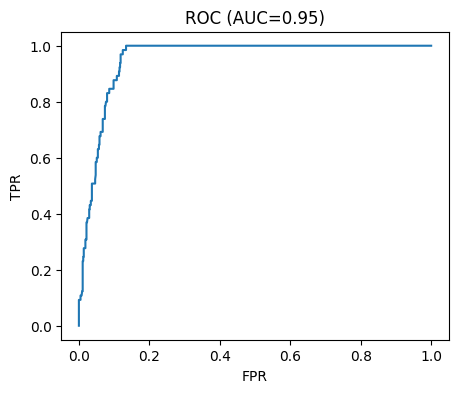

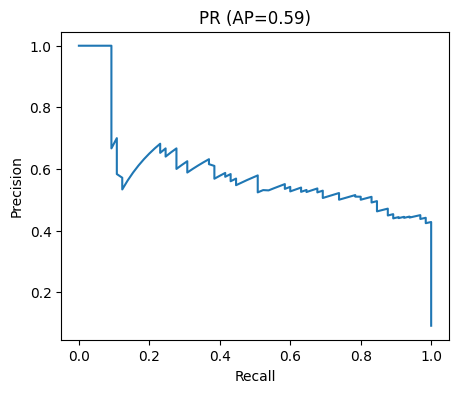

In [12]:

X = data_df[feature_cols].to_numpy()
y = data_df['label'].to_numpy()
groups = data_df['group'].to_numpy()

sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
probs = np.zeros_like(y, dtype=float)

for fold, (tr, te) in enumerate(sgkf.split(X, y, groups=groups), 1):
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('gb', GradientBoostingClassifier(random_state=RANDOM_SEED)),
    ])
    pipe.fit(X[tr], y[tr])
    probs[te] = pipe.predict_proba(X[te])[:, 1]
    print(f'Fold {fold} done.')

auc = roc_auc_score(y, probs)
ap  = average_precision_score(y, probs)
print('AUC:', round(auc, 3), '   AP:', round(ap, 3))

# Curves
fpr, tpr, _ = roc_curve(y, probs)
prec, rec, _ = precision_recall_curve(y, probs)
fig, ax = plt.subplots(figsize=(5,4)); ax.plot(fpr, tpr); ax.set_title(f'ROC (AUC={auc:.2f})'); ax.set_xlabel('FPR'); ax.set_ylabel('TPR'); plt.show()
fig, ax = plt.subplots(figsize=(5,4)); ax.plot(rec, prec); ax.set_title(f'PR (AP={ap:.2f})'); ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); plt.show()


## 12) Fit final model + importance

         feature  importance
1           bio4    0.481076
3          bio15    0.129839
2          bio12    0.123698
7  dist_river_km    0.091260
4           elev    0.051252
6  dist_coast_km    0.050512
5          slope    0.044352
0           bio1    0.028011


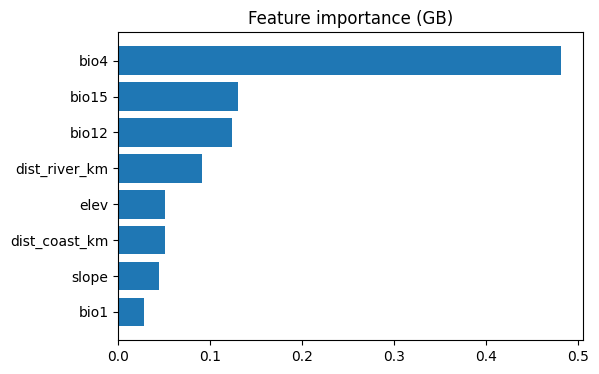

In [13]:

pipe_final = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_SEED)),
])
pipe_final.fit(X, y)

gb = pipe_final.named_steps['gb']
imp = pd.DataFrame({'feature': feature_cols, 'importance': gb.feature_importances_}).sort_values('importance', ascending=False)
print(imp)

fig, ax = plt.subplots(figsize=(6,4))
ax.barh(imp['feature'], imp['importance'])
ax.set_title('Feature importance (GB)')
plt.gca().invert_yaxis(); plt.show()


## 13) Predict suitability on a coarse grid

Grid points: 8468


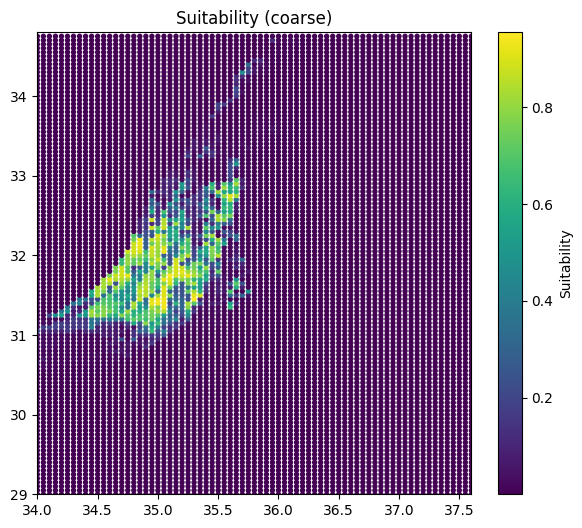

In [14]:

def predict_grid(step_deg=0.05):
    lons = np.arange(W_BOUND, E_BOUND, step_deg)
    lats = np.arange(S_BOUND, N_BOUND, step_deg)
    grid = pd.DataFrame(list(itertools.product(lons, lats)), columns=['lon','lat'])
    # sample rasters
    for v, da in bio_layers.items():
        grid[f'bio{v}'] = list(da.sel(x=xr.DataArray(grid['lon'].values, dims='z'),
                                      y=xr.DataArray(grid['lat'].values, dims='z'), method='nearest').values)
    grid['elev']  = list(elev_ll.sel(x=xr.DataArray(grid['lon'].values, dims='z'),
                                     y=xr.DataArray(grid['lat'].values, dims='z'), method='nearest').values)
    grid['slope'] = list(slope_ll.sel(x=xr.DataArray(grid['lon'].values, dims='z'),
                                     y=xr.DataArray(grid['lat'].values, dims='z'), method='nearest').values)
    # distances
    gdf_tmp = gpd.GeoDataFrame(grid[['lon','lat']], geometry=gpd.points_from_xy(grid['lon'], grid['lat']), crs=4326)
    dc, dr = compute_distance_features(gdf_tmp, coast_gdf, rivers_gdf)
    grid['dist_coast_km'] = dc
    grid['dist_river_km'] = dr

    # predict
    Xg = grid[feature_cols].to_numpy()
    grid['suit'] = pipe_final.predict_proba(Xg)[:,1]
    return grid

grid_df = predict_grid(step_deg=0.05)
print('Grid points:', len(grid_df))

fig, ax = plt.subplots(figsize=(7,6))
sc = ax.scatter(grid_df['lon'], grid_df['lat'], c=grid_df['suit'], s=8)
ax.set_title('Suitability (coarse)'); ax.set_xlim(W_BOUND, E_BOUND); ax.set_ylim(S_BOUND, N_BOUND)
plt.colorbar(sc, ax=ax, label='Suitability'); plt.show()


## 14) Save outputs

In [15]:

data_df.to_parquet(OUT_DIR / 'points_with_features_v2.parquet', index=False)
imp.to_csv(OUT_DIR / 'feature_importance_v2.csv', index=False)
grid_df.to_parquet(OUT_DIR / 'suitability_grid_v2.parquet', index=False)
print('Saved to:', OUT_DIR)


Saved to: outputs


In [16]:
# --- OOF predictions + fold IDs ---
# Assumes: X, y, groups, probs, data_df, OUT_DIR, N_FOLDS, RANDOM_SEED are already defined,
# and the same StratifiedGroupKFold settings were used above.

from sklearn.model_selection import StratifiedGroupKFold
import numpy as np
import pandas as pd

sgkf = StratifiedGroupKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

fold_id = np.full(len(y), -1, dtype=int)
for fold, (_, te) in enumerate(sgkf.split(X, y, groups=groups), 1):
    fold_id[te] = fold

oof_df = data_df[['lon','lat']].copy()
oof_df['label']   = y
oof_df['oof_prob'] = probs
oof_df['group']   = groups
oof_df['fold']    = fold_id

oof_csv = OUT_DIR / 'oof_predictions_v2.csv'
oof_par = OUT_DIR / 'oof_predictions_v2.parquet'

oof_df.to_csv(oof_csv, index=False)
try:
    oof_df.to_parquet(oof_par, index=False)
except Exception as e:
    print("Parquet save skipped (pyarrow/fastparquet missing):", e)

print("Saved:", oof_csv, "and (if available) ", oof_par)


Saved: outputs/oof_predictions_v2.csv and (if available)  outputs/oof_predictions_v2.parquet


Saved PD plot: outputs/pd_bio4.png


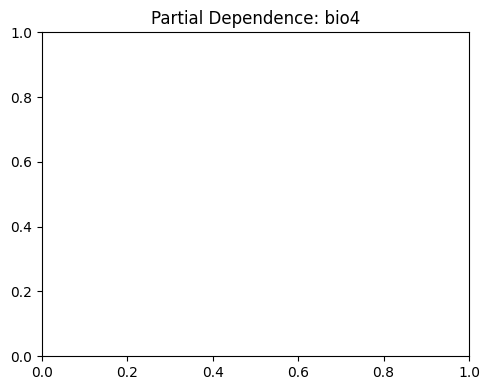

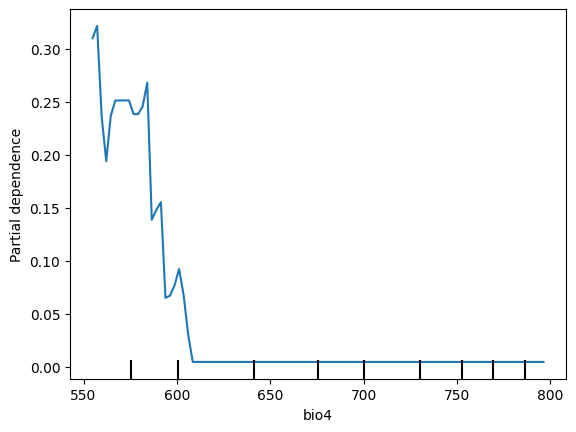

Saved PD plot: outputs/pd_dist_river_km.png


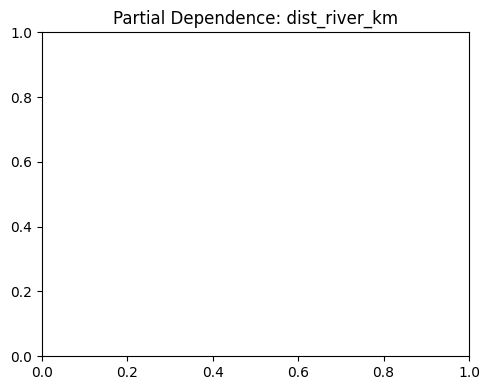

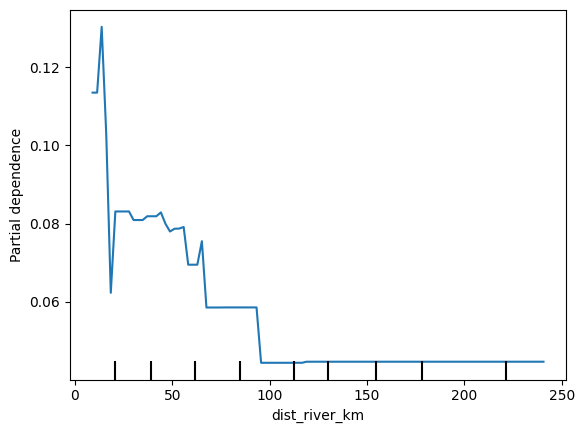

In [17]:
# --- PD plots for bio4 & dist_river_km ---
# Assumes: feature_cols, X, OUT_DIR are defined and the final model pipeline is fitted.
# Works with either `final_pipe` or `pipe_final`.

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay as PDP

# Resolve the fitted pipeline
model = None
for name in ('final_pipe', 'pipe_final'):
    if name in globals():
        model = globals()[name]
        break
assert model is not None, "Run the cell that fits the final model (final_pipe/pipe_final) first."

# Use a DataFrame so we can refer to features by name
X_df = pd.DataFrame(X, columns=feature_cols)

targets = []
for fname in ['bio4', 'dist_river_km']:
    if fname in feature_cols:
        targets.append(fname)
    else:
        print(f"Warning: {fname} not found in feature_cols, skipping.")

for fname in targets:
    fig, ax = plt.subplots(figsize=(5,4))
    PDP.from_estimator(model, X_df, [fname])
    ax.set_title(f'Partial Dependence: {fname}')
    fig.tight_layout()
    out_png = OUT_DIR / f'pd_{fname}.png'
    fig.savefig(out_png, dpi=200)
    print("Saved PD plot:", out_png)
    plt.show()


In [18]:
# --- Folium HTML export from grid_df ---
# Assumes: grid_df (with columns: lon, lat, suit), sites_gdf, and OUT_DIR exist.

# If needed, install in your env:
# !pip install folium branca

import folium
from folium.plugins import HeatMap
import branca.colormap as cm

center_lat = float((S_BOUND + N_BOUND) / 2.0)
center_lon = float((W_BOUND + E_BOUND) / 2.0)

m = folium.Map(location=[center_lat, center_lon], zoom_start=7, tiles='CartoDB positron')

# HeatMap of suitability (lat, lon, weight)
heat_data = grid_df[['lat','lon','suit']].astype(float).values.tolist()
HeatMap(heat_data, radius=14, blur=22, min_opacity=0.2, max_opacity=0.9, max_zoom=8).add_to(m)

# Plot a sample of site points for reference
n_show = min(1500, len(sites_gdf))
for _, row in sites_gdf.sample(n_show, random_state=42).iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2.5, weight=0, fill=True, fill_opacity=0.9, color='#111111'
    ).add_to(m)

# Legend for suitability
colormap = cm.LinearColormap(['#2c7bb6', '#abd9e9', '#ffffbf', '#fdae61', '#d7191c'],
                             vmin=float(grid_df['suit'].min()),
                             vmax=float(grid_df['suit'].max()))
colormap.caption = 'Predicted suitability'
colormap.add_to(m)

out_html = OUT_DIR / 'map_v2_suitability.html'
m.save(out_html)
print('Saved folium map to:', out_html)


Saved folium map to: outputs/map_v2_suitability.html


In [19]:
# === Save AUC/AP (and extras) to disk ===
# Requires: y, probs, OUT_DIR already defined by the CV section.
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import numpy as np

# Recompute defensively if needed
if 'auc' not in globals() or 'ap' not in globals():
    assert 'y' in globals() and 'probs' in globals(), "Run the CV cell first to define y and probs."
    auc = roc_auc_score(y, probs)
    ap  = average_precision_score(y, probs)

prev  = float(np.mean(y))
brier = float(brier_score_loss(y, probs))

out_txt = OUT_DIR / "metrics_v2.txt"
with open(out_txt, "w") as f:
    f.write(f"AUC={auc:.3f}\n")
    f.write(f"AP={ap:.3f}\n")
    f.write(f"Prevalence={prev:.4f}\n")
    f.write(f"Brier={brier:.4f}\n")
print("Saved metrics to:", out_txt)


Saved metrics to: outputs/metrics_v2.txt


Saved PD plot: outputs/pd_bio4.png


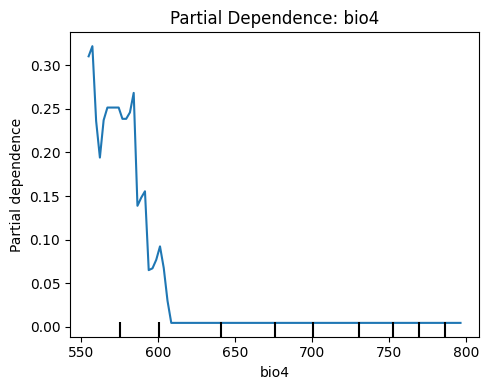

Saved PD plot: outputs/pd_dist_river_km.png


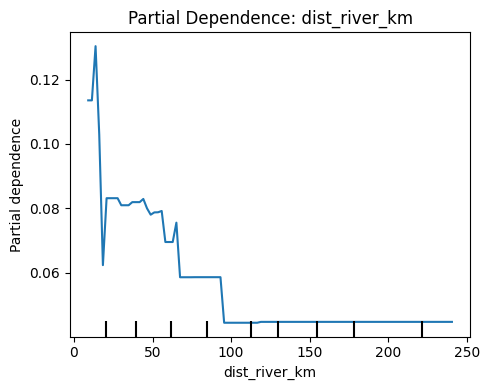

In [20]:
# === Fixed Partial Dependence (PD) plots for 'bio4' and 'dist_river_km' ===
# Requires: final model fitted (final_pipe or pipe_final), X, feature_cols, OUT_DIR.
from sklearn.inspection import PartialDependenceDisplay as PDP
import matplotlib.pyplot as plt
import pandas as pd

# Resolve fitted pipeline
model = None
for name in ("final_pipe", "pipe_final"):
    if name in globals():
        model = globals()[name]
        break
assert model is not None, "Fit the final model (final_pipe/pipe_final) before running PD."

# Ensure a DataFrame with named columns
X_df = pd.DataFrame(X, columns=feature_cols) if not isinstance(X, pd.DataFrame) else X

targets = [f for f in ["bio4", "dist_river_km"] if f in X_df.columns]
if not targets:
    raise ValueError("Neither 'bio4' nor 'dist_river_km' present in feature_cols.")

for fname in targets:
    fig, ax = plt.subplots(figsize=(5, 4))
    PDP.from_estimator(
        model,
        X_df,
        [fname],
        ax=ax,
        response_method="predict_proba"  # ensures probability-scale PD
    )
    ax.set_title(f"Partial Dependence: {fname}")
    ax.grid(True, alpha=0.3)
    fig.tight_layout()
    out_png = OUT_DIR / f"pd_{fname}.png"
    fig.savefig(out_png, dpi=200)
    print("Saved PD plot:", out_png)
    plt.show()
